In [2]:
from src.detector.data_obj_detect import MOT16ObjDetect
from src.detector.visualize import visualize_detection
from src.detector.object_detector import init_detector
from src.detector.utils import obj_detect_transforms, full_image_box
import os
from argparse import Namespace
import glob
import torchvision
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm



Using cache found in C:\Users\arthu/.cache\torch\hub\facebookresearch_detr_main


In [3]:
args = Namespace()
args.obj_detect_config_path = "config\\obj_detect\\maskrcnn_from_external_proposals.json"
args.raw_data_dir = "data/market/bounding_box_train"

config = json.load(open(args.obj_detect_config_path, "r"))
obj_detect = init_detector(**config)
obj_detect.eval()

output_dir = args.raw_data_dir + "_masked"
raw_image_paths = glob.glob(os.path.join(args.raw_data_dir, "*.jpg"))
output_image_paths = [
    os.path.join(output_dir, file_name)
    for file_name in os.listdir(args.raw_data_dir)
]

start = 0
raw_image_paths = raw_image_paths[start:]
output_image_paths = output_image_paths[start:]

remove_count = 0
for img_count, (output_image_path, raw_image_path) in tqdm(
    enumerate(zip(output_image_paths, raw_image_paths), start=1),
    total=len(output_image_paths),
    desc="mask images...",
):
    raw_image_path = os.path.join(args.raw_data_dir, "0002_c5s1_000476_02.jpg")
    image = TF.to_tensor(Image.open(raw_image_path).convert("RGB"))

    with torch.no_grad():
        det = obj_detect.predict_on_external_proposals(
            images=[image], proposals=[full_image_box(image).unsqueeze(0)]
        )[0]
    break

mask images...:   0%|          | 0/12937 [00:02<?, ?it/s]


In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
mask_confidence_thresh = 0.6
model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0))["out"]
    masks = F.softmax(logits, dim=1) > mask_confidence_thresh
    pedestrian_mask = masks[:, 15] 


Using cache found in C:\Users\arthu/.cache\torch\hub\pytorch_vision_v0.10.0


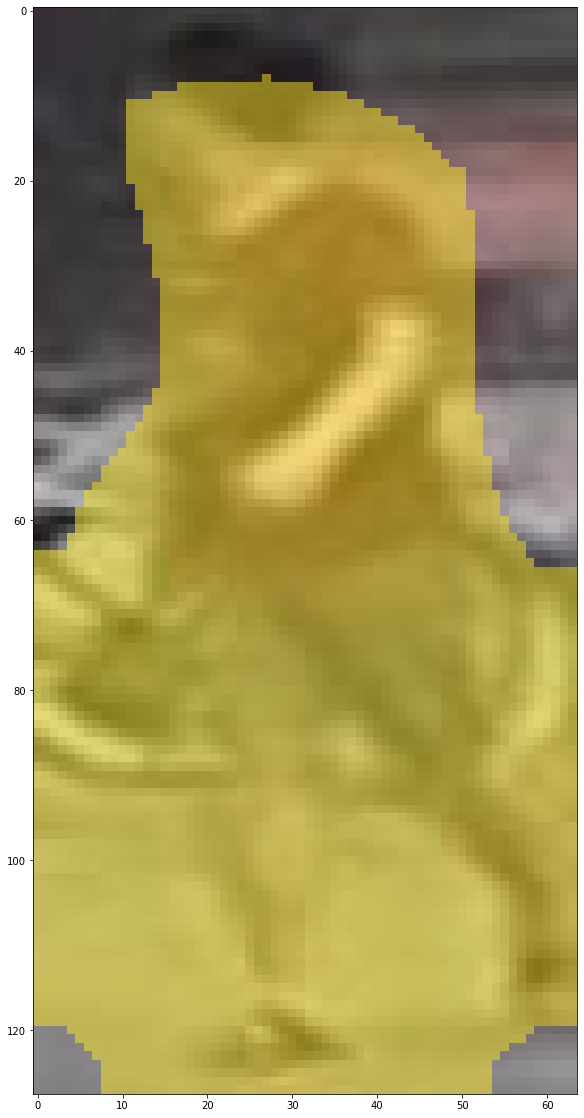

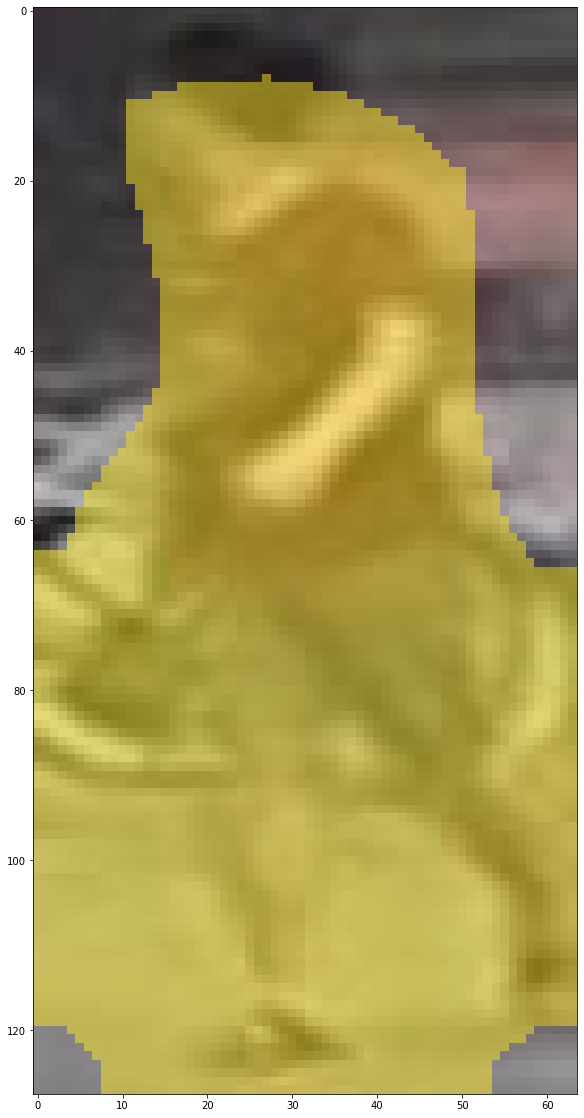

In [11]:
visualize_detection(image, masks=pedestrian_mask)